but : prédire les zone de fragilité de ARNm

à partir de : séquence d'arn, les appariements prédis de structure secondaire  et quel méthode utilisée
en input on a  le jeux de données anoté mais pas complet. 

On part des réseaux récurrents: on a un input et un output, l'idée est qu'on va réinjecter de l'info de l'input précedent dans l'input présent. (réseau neuromemetique saint)



In [2]:
import shutil
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#import tensorflow as tf
from multiprocessing import Pool

import os
import gc
import json
import glob
from tqdm.notebook import tqdm


In [23]:
pretrain_dir = None # model dir for resuming training. if None, train from scrach

one_fold = False # if True, train model at only first fold. use if you try a new idea quickly.
run_test = False # if True, use small data. you can check whether this code run or not
denoise = True # if True, use train data whose signal_to_noise > 1

ae_epochs = 20 # epoch of training of denoising auto encoder
ae_epochs_each = 5 # epoch of training of denoising auto encoder each time. 
                   # I use train data (seqlen = 107) and private test data (seqlen = 130) for auto encoder training.
                   # I dont know how to easily fit keras model to use both of different shape data simultaneously, 
                   # so I call fit function several times. 
ae_batch_size = 32

epochs_list = [30, 10, 3, 3, 5, 5]
batch_size_list = [8, 16, 32, 64, 128, 256] 

## copy pretrain model to working dir

if pretrain_dir is not None:
    for d in glob.glob(pretrain_dir + "*"):
        shutil.copy(d, ".")

In [24]:
# ceci permet de repertorier les fichier existant dans le repertoire 
for dirname,_, filenames in os.walk('/home/lynda/Bureau/covid_vaccine'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/home/lynda/Bureau/covid_vaccine/sample_submission.csv
/home/lynda/Bureau/covid_vaccine/stanford-covid-vaccine.zip
/home/lynda/Bureau/covid_vaccine/projet_DL.odt
/home/lynda/Bureau/covid_vaccine/Untitled.ipynb
/home/lynda/Bureau/covid_vaccine/Untitled1.ipynb
/home/lynda/Bureau/covid_vaccine/.ipynb_checkpoints/Untitled-checkpoint.ipynb
/home/lynda/Bureau/covid_vaccine/.ipynb_checkpoints/Untitled1-checkpoint.ipynb
/home/lynda/Bureau/covid_vaccine/src/script.py
/home/lynda/Bureau/covid_vaccine/src/Untitled1.ipynb
/home/lynda/Bureau/covid_vaccine/Data/test.json
/home/lynda/Bureau/covid_vaccine/Data/train.json
/home/lynda/Bureau/covid_vaccine/Data/bpps/id_0dc68084b.npy
/home/lynda/Bureau/covid_vaccine/Data/bpps/id_f537c2540.npy
/home/lynda/Bureau/covid_vaccine/Data/bpps/id_57bf10196.npy
/home/lynda/Bureau/covid_vaccine/Data/bpps/id_651ca45dd.npy
/home/lynda/Bureau/covid_vaccine/Data/bpps/id_681f85e31.npy
/home/lynda/Bureau/covid_vaccine/Data/bpps/id_a71b09e2c.npy
/home/lynda/Bureau/covid_va

/home/lynda/Bureau/covid_vaccine/Data/bpps/id_a89303f48.npy
/home/lynda/Bureau/covid_vaccine/Data/bpps/id_9ca4c4379.npy
/home/lynda/Bureau/covid_vaccine/Data/bpps/id_5bb59e23b.npy
/home/lynda/Bureau/covid_vaccine/Data/bpps/id_f85849edf.npy
/home/lynda/Bureau/covid_vaccine/Data/bpps/id_534b8a458.npy
/home/lynda/Bureau/covid_vaccine/Data/bpps/id_54ef2ae73.npy
/home/lynda/Bureau/covid_vaccine/Data/bpps/id_fcf051e33.npy
/home/lynda/Bureau/covid_vaccine/Data/bpps/id_5b55490a1.npy
/home/lynda/Bureau/covid_vaccine/Data/bpps/id_c065b5e80.npy
/home/lynda/Bureau/covid_vaccine/Data/bpps/id_a4f939bd6.npy
/home/lynda/Bureau/covid_vaccine/Data/bpps/id_26c1cde85.npy
/home/lynda/Bureau/covid_vaccine/Data/bpps/id_34ee4f665.npy
/home/lynda/Bureau/covid_vaccine/Data/bpps/id_08454c85c.npy
/home/lynda/Bureau/covid_vaccine/Data/bpps/id_2bcc7c0f1.npy
/home/lynda/Bureau/covid_vaccine/Data/bpps/id_60fb915b5.npy
/home/lynda/Bureau/covid_vaccine/Data/bpps/id_fe7a3fdc6.npy
/home/lynda/Bureau/covid_vaccine/Data/bp

/home/lynda/Bureau/covid_vaccine/Data/bpps/id_8d9e5c066.npy
/home/lynda/Bureau/covid_vaccine/Data/bpps/id_97b2f3ff8.npy
/home/lynda/Bureau/covid_vaccine/Data/bpps/id_ce01a6a50.npy
/home/lynda/Bureau/covid_vaccine/Data/bpps/id_86f662f37.npy
/home/lynda/Bureau/covid_vaccine/Data/bpps/id_71b8baf2b.npy
/home/lynda/Bureau/covid_vaccine/Data/bpps/id_330561c89.npy
/home/lynda/Bureau/covid_vaccine/Data/bpps/id_e824cd38a.npy
/home/lynda/Bureau/covid_vaccine/Data/bpps/id_e064cb65b.npy
/home/lynda/Bureau/covid_vaccine/Data/bpps/id_7d493ecfb.npy
/home/lynda/Bureau/covid_vaccine/Data/bpps/id_830154306.npy
/home/lynda/Bureau/covid_vaccine/Data/bpps/id_73007d61b.npy
/home/lynda/Bureau/covid_vaccine/Data/bpps/id_9c6ccc627.npy
/home/lynda/Bureau/covid_vaccine/Data/bpps/id_ac7250d36.npy
/home/lynda/Bureau/covid_vaccine/Data/bpps/id_93c3a613e.npy
/home/lynda/Bureau/covid_vaccine/Data/bpps/id_b544084c6.npy
/home/lynda/Bureau/covid_vaccine/Data/bpps/id_8d7689482.npy
/home/lynda/Bureau/covid_vaccine/Data/bp

/home/lynda/Bureau/covid_vaccine/Data/bpps/id_b511cd74a.npy
/home/lynda/Bureau/covid_vaccine/Data/bpps/id_9b13c50b2.npy
/home/lynda/Bureau/covid_vaccine/Data/bpps/id_ba7411e5e.npy
/home/lynda/Bureau/covid_vaccine/Data/bpps/id_3c7eac45d.npy
/home/lynda/Bureau/covid_vaccine/Data/bpps/id_2c6aff43d.npy
/home/lynda/Bureau/covid_vaccine/Data/bpps/id_74d06fdf7.npy
/home/lynda/Bureau/covid_vaccine/Data/bpps/id_0e69a3073.npy
/home/lynda/Bureau/covid_vaccine/Data/bpps/id_e9e4c4918.npy
/home/lynda/Bureau/covid_vaccine/Data/bpps/id_39564a7ae.npy
/home/lynda/Bureau/covid_vaccine/Data/bpps/id_665d59309.npy
/home/lynda/Bureau/covid_vaccine/Data/bpps/id_a997c2a5b.npy
/home/lynda/Bureau/covid_vaccine/Data/bpps/id_68954ba34.npy
/home/lynda/Bureau/covid_vaccine/Data/bpps/id_688c4a4a8.npy
/home/lynda/Bureau/covid_vaccine/Data/bpps/id_b51e2f1f4.npy
/home/lynda/Bureau/covid_vaccine/Data/bpps/id_bd8a2932f.npy
/home/lynda/Bureau/covid_vaccine/Data/bpps/id_ee1833a39.npy
/home/lynda/Bureau/covid_vaccine/Data/bp

/home/lynda/Bureau/covid_vaccine/Data/bpps/id_0c82ce7e3.npy
/home/lynda/Bureau/covid_vaccine/Data/bpps/id_ddb02965c.npy
/home/lynda/Bureau/covid_vaccine/Data/bpps/id_45dba7199.npy
/home/lynda/Bureau/covid_vaccine/Data/bpps/id_7c54fbf18.npy
/home/lynda/Bureau/covid_vaccine/Data/bpps/id_847b1f8fa.npy
/home/lynda/Bureau/covid_vaccine/Data/bpps/id_d3aed2699.npy
/home/lynda/Bureau/covid_vaccine/Data/bpps/id_238e3b19b.npy
/home/lynda/Bureau/covid_vaccine/Data/bpps/id_892631452.npy
/home/lynda/Bureau/covid_vaccine/Data/bpps/id_5d93bdda1.npy
/home/lynda/Bureau/covid_vaccine/Data/bpps/id_805a29d27.npy
/home/lynda/Bureau/covid_vaccine/Data/bpps/id_fc4b93521.npy
/home/lynda/Bureau/covid_vaccine/Data/bpps/id_2acaec4d9.npy
/home/lynda/Bureau/covid_vaccine/Data/bpps/id_18820f795.npy
/home/lynda/Bureau/covid_vaccine/Data/bpps/id_4b7dd84f2.npy
/home/lynda/Bureau/covid_vaccine/Data/bpps/id_003ab2445.npy
/home/lynda/Bureau/covid_vaccine/Data/bpps/id_aaf57623f.npy
/home/lynda/Bureau/covid_vaccine/Data/bp

## Récuperer les fichiers et traitement des bruits 

In [5]:
#ouvrir les fichiers json test et train 
train = pd.read_json('/home/lynda/Bureau/covid_vaccine/train.json', lines = True)  # 2400rows * 19columns
print("longueur fichier train non filtré {}".format(len(train)))
if denoise:
    train = train[train.signal_to_noise > 1] #filter le signal bruit ::: 2096 rows 
test = pd.read_json('/home/lynda/Bureau/covid_vaccine/test.json', lines = True)
sub = pd.read_csv("/home/lynda/Bureau/covid_vaccine/sample_submission.csv")


test_pub = test[test["seq_length"] == 107]   #output 68 comment traité?? 
test_pri = test[test["seq_length"] == 130]   #91 de output

print("longueur fichier train filtré {}".format(len(train)))
print("longueur fichier test {}".format(len(test)))

longueur fichier train non filtré 2400
longueur fichier train filtré 2096
longueur fichier test 3634


In [36]:
if run_test: ## to test 
    train = train[:30]
    test_pub = test_pub[:30]
    test_pri = test_pri[:30]

,index,id,sequence,structure,predicted_loop_type,signal_to_noise,SN_filter,seq_length,seq_scored,reactivity_error,deg_error_Mg_pH10,deg_error_pH10,deg_error_Mg_50C,deg_error_50C,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,0,id_001f94081,GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...,.....((((((.......)))).)).((.....((..((((((......,EEEEESSSSSSHHHHHHHSSSSBSSXSSIIIIISSIISSSSSSHHH...,6.894,1,107,68,"[0.1359, 0.20700000000000002, 0.1633, 0.1452, ...","[0.26130000000000003, 0.38420000000000004, 0.1...","[0.2631, 0.28600000000000003, 0.0964, 0.1574, ...","[0.1501, 0.275, 0.0947, 0.18660000000000002, 0...","[0.2167, 0.34750000000000003, 0.188, 0.2124, 0...","[0.3297, 1.5693000000000001, 1.1227, 0.8686, 0...","[0.7556, 2.983, 0.2526, 1.3789, 0.637600000000...","[2.3375, 3.5060000000000002, 0.3008, 1.0108, 0...","[0.35810000000000003, 2.9683, 0.2589, 1.4552, ...","[0.6382, 3.4773, 0.9988, 1.3228, 0.78770000000..."
1,2,id_006f36f57,GGAAAGUGCUCAGAUAAGCUAAGCUCGAAUAGCAAUCGAAUAGAAU...,.....((((.((.....((((.(((.....)))..((((......)...,EEEEESSSSISSIIIIISSSSMSSSHHHHHSSSMMSSSSHHHHHHS...,8.800,1,107,68,"[0.0931, 0.13290000000000002, 0.11280000000000...","[0.1365, 0.2237, 0.1812, 0.1333, 0.1148, 0.160...","[0.17020000000000002, 0.178, 0.111, 0.091, 0.0...","[0.1033, 0.1464, 0.1126, 0.09620000000000001, ...","[0.14980000000000002, 0.1761, 0.1517, 0.116700...","[0.44820000000000004, 1.4822, 1.1819, 0.743400...","[0.2504, 1.4021, 0.9804, 0.49670000000000003, ...","[2.243, 2.9361, 1.0553, 0.721, 0.6396000000000...","[0.5163, 1.6823000000000001, 1.0426, 0.7902, 0...","[0.9501000000000001, 1.7974999999999999, 1.499..."
2,5,id_00ab2d761,GGAAAGCGCCGCGGCGGUAGCGGCAGCGAGGAGCGCUACCAAGGCA...,.....(.(((((.(((((((((...........)))))))..(((....,EEEEESISSSSSISSSSSSSSSHHHHHHHHHHHSSSSSSSMMSSSH...,4.136,1,107,68,"[0.1942, 0.2041, 0.1626, 0.1213, 0.10590000000...","[0.2726, 0.2984, 0.21660000000000001, 0.1637, ...","[0.3393, 0.2728, 0.2005, 0.1703, 0.1495, 0.134...","[0.165, 0.20520000000000002, 0.179, 0.1333, 0....","[0.2864, 0.24710000000000001, 0.2222, 0.1903, ...","[0.7642, 1.6641, 1.0622, 0.5008, 0.4107, 0.133...","[0.9559000000000001, 1.9442, 1.0114, 0.5105000...","[1.9554, 2.1298, 1.0403, 0.609, 0.5486, 0.386,...","[0.22460000000000002, 1.7281, 1.381, 0.6623, 0...","[0.5882000000000001, 1.1786, 0.9704, 0.6035, 0..."
3,6,id_00abef1d7,GGAAAACAAUUGCAUCGUUAGUACGACUCCACAGCGUAAGCUGUGG...,.........((((((((......((((((((((((....)))))))...,EEEEEEEEESSSSSSSSIIIIIISSSSSSSSSSSSHHHHSSSSSSS...,2.485,1,107,68,"[0.422, 0.5478000000000001, 0.4749000000000000...","[0.4801, 0.7943, 0.42160000000000003, 0.397300...","[0.9822000000000001, 1.272, 0.6940000000000001...","[0.5827, 0.7555000000000001, 0.5949, 0.4511, 0...","[0.9306000000000001, 1.0496, 0.5844, 0.7796000...","[0.895, 2.3377, 2.2305, 2.003, 1.9006, 1.0373,...","[0.46040000000000003, 3.6695, 0.78550000000000...","[2.7711, 7.365, 1.6924000000000001, 1.43840000...","[1.073, 2.8604000000000003, 1.9936, 1.0273, 1....","[2.0964, 3.3688000000000002, 0.6399, 2.1053, 1..."
4,7,id_00b436dec,GGAAAUCAUCGAGGACGGGUCCGUUCAGCACGCGAAAGCGUCGUGA...,.....(((((((((((..(((((((((..((((....))))..)))...,EEEEESSSSSSSSSSSIISSSSSSSSSIISSSSHHHHSSSSIISSS...,1.727,1,107,68,"[0.4843, 0.5233, 0.4554, 0.43520000000000003, ...","[0.8719, 1.0307, 0.6649, 0.34500000000000003, ...","[0.7045, 0.7775000000000001, 0.5662, 0.4561, 0...","[0.384, 0.723, 0.4766, 0.30260000000000004, 0....","[0.7429, 0.9137000000000001, 0.480400000000000...","[1.1576, 1.5137, 1.3382, 1.5622, 1.2121, 0.295...","[1.6912, 5.2652, 2.3901, 0.45890000000000003, ...","[1.8641, 2.3767, 1.149, 1.0132, 0.9876, 0.0, 0...","[0.49060000000000004, 4.6339, 1.95860000000000...","[1.2852000000000001, 2.5460000000000003, 0.234..."


In [6]:
# chargement des données  en correspondance avec les id dans des array

As = []
for id in tqdm(train["id"]):
    a = np.load(f'/home/lynda/Bureau/covid_vaccine/bpps/{id}.npy')
    As.append(a)
As = np.array(As)


As_pri = []
for id in tqdm(test_pri["id"]):
    a = np.load(f"/home/lynda/Bureau/covid_vaccine/bpps/{id}.npy")
    As_pri.append(a)
As_pri = np.array(As_pri)

As_pub = []
for id in tqdm(test_pub["id"]):
    a = np.load(f"/home/lynda/Bureau/covid_vaccine/bpps/{id}.npy")
    As_pub.append(a)
As_pub = np.array(As_pub)


In [7]:
train.shape

(2096, 19)

In [8]:
train.head()

,index,id,sequence,structure,predicted_loop_type,signal_to_noise,SN_filter,seq_length,seq_scored,reactivity_error,deg_error_Mg_pH10,deg_error_pH10,deg_error_Mg_50C,deg_error_50C,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,0,id_001f94081,GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...,.....((((((.......)))).)).((.....((..((((((......,EEEEESSSSSSHHHHHHHSSSSBSSXSSIIIIISSIISSSSSSHHH...,6.894,1,107,68,"[0.1359, 0.20700000000000002, 0.1633, 0.1452, ...","[0.26130000000000003, 0.38420000000000004, 0.1...","[0.2631, 0.28600000000000003, 0.0964, 0.1574, ...","[0.1501, 0.275, 0.0947, 0.18660000000000002, 0...","[0.2167, 0.34750000000000003, 0.188, 0.2124, 0...","[0.3297, 1.5693000000000001, 1.1227, 0.8686, 0...","[0.7556, 2.983, 0.2526, 1.3789, 0.637600000000...","[2.3375, 3.5060000000000002, 0.3008, 1.0108, 0...","[0.35810000000000003, 2.9683, 0.2589, 1.4552, ...","[0.6382, 3.4773, 0.9988, 1.3228, 0.78770000000..."
2,2,id_006f36f57,GGAAAGUGCUCAGAUAAGCUAAGCUCGAAUAGCAAUCGAAUAGAAU...,.....((((.((.....((((.(((.....)))..((((......)...,EEEEESSSSISSIIIIISSSSMSSSHHHHHSSSMMSSSSHHHHHHS...,8.800,1,107,68,"[0.0931, 0.13290000000000002, 0.11280000000000...","[0.1365, 0.2237, 0.1812, 0.1333, 0.1148, 0.160...","[0.17020000000000002, 0.178, 0.111, 0.091, 0.0...","[0.1033, 0.1464, 0.1126, 0.09620000000000001, ...","[0.14980000000000002, 0.1761, 0.1517, 0.116700...","[0.44820000000000004, 1.4822, 1.1819, 0.743400...","[0.2504, 1.4021, 0.9804, 0.49670000000000003, ...","[2.243, 2.9361, 1.0553, 0.721, 0.6396000000000...","[0.5163, 1.6823000000000001, 1.0426, 0.7902, 0...","[0.9501000000000001, 1.7974999999999999, 1.499..."
5,5,id_00ab2d761,GGAAAGCGCCGCGGCGGUAGCGGCAGCGAGGAGCGCUACCAAGGCA...,.....(.(((((.(((((((((...........)))))))..(((....,EEEEESISSSSSISSSSSSSSSHHHHHHHHHHHSSSSSSSMMSSSH...,4.136,1,107,68,"[0.1942, 0.2041, 0.1626, 0.1213, 0.10590000000...","[0.2726, 0.2984, 0.21660000000000001, 0.1637, ...","[0.3393, 0.2728, 0.2005, 0.1703, 0.1495, 0.134...","[0.165, 0.20520000000000002, 0.179, 0.1333, 0....","[0.2864, 0.24710000000000001, 0.2222, 0.1903, ...","[0.7642, 1.6641, 1.0622, 0.5008, 0.4107, 0.133...","[0.9559000000000001, 1.9442, 1.0114, 0.5105000...","[1.9554, 2.1298, 1.0403, 0.609, 0.5486, 0.386,...","[0.22460000000000002, 1.7281, 1.381, 0.6623, 0...","[0.5882000000000001, 1.1786, 0.9704, 0.6035, 0..."
6,6,id_00abef1d7,GGAAAACAAUUGCAUCGUUAGUACGACUCCACAGCGUAAGCUGUGG...,.........((((((((......((((((((((((....)))))))...,EEEEEEEEESSSSSSSSIIIIIISSSSSSSSSSSSHHHHSSSSSSS...,2.485,1,107,68,"[0.422, 0.5478000000000001, 0.4749000000000000...","[0.4801, 0.7943, 0.42160000000000003, 0.397300...","[0.9822000000000001, 1.272, 0.6940000000000001...","[0.5827, 0.7555000000000001, 0.5949, 0.4511, 0...","[0.9306000000000001, 1.0496, 0.5844, 0.7796000...","[0.895, 2.3377, 2.2305, 2.003, 1.9006, 1.0373,...","[0.46040000000000003, 3.6695, 0.78550000000000...","[2.7711, 7.365, 1.6924000000000001, 1.43840000...","[1.073, 2.8604000000000003, 1.9936, 1.0273, 1....","[2.0964, 3.3688000000000002, 0.6399, 2.1053, 1..."
7,7,id_00b436dec,GGAAAUCAUCGAGGACGGGUCCGUUCAGCACGCGAAAGCGUCGUGA...,.....(((((((((((..(((((((((..((((....))))..)))...,EEEEESSSSSSSSSSSIISSSSSSSSSIISSSSHHHHSSSSIISSS...,1.727,1,107,68,"[0.4843, 0.5233, 0.4554, 0.43520000000000003, ...","[0.8719, 1.0307, 0.6649, 0.34500000000000003, ...","[0.7045, 0.7775000000000001, 0.5662, 0.4561, 0...","[0.384, 0.723, 0.4766, 0.30260000000000004, 0....","[0.7429, 0.9137000000000001, 0.480400000000000...","[1.1576, 1.5137, 1.3382, 1.5622, 1.2121, 0.295...","[1.6912, 5.2652, 2.3901, 0.45890000000000003, ...","[1.8641, 2.3767, 1.149, 1.0132, 0.9876, 0.0, 0...","[0.49060000000000004, 4.6339, 1.95860000000000...","[1.2852000000000001, 2.5460000000000003, 0.234..."


In [9]:
train.describe()

train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2096 entries, 0 to 2399
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   index                2096 non-null   int64  
 1   id                   2096 non-null   object 
 2   sequence             2096 non-null   object 
 3   structure            2096 non-null   object 
 4   predicted_loop_type  2096 non-null   object 
 5   signal_to_noise      2096 non-null   float64
 6   SN_filter            2096 non-null   int64  
 7   seq_length           2096 non-null   int64  
 8   seq_scored           2096 non-null   int64  
 9   reactivity_error     2096 non-null   object 
 10  deg_error_Mg_pH10    2096 non-null   object 
 11  deg_error_pH10       2096 non-null   object 
 12  deg_error_Mg_50C     2096 non-null   object 
 13  deg_error_50C        2096 non-null   object 
 14  reactivity           2096 non-null   object 
 15  deg_Mg_pH10          2096 non-null   o

# Définir les variables cibles de la prédiction 

In [11]:
targets = list(sub.columns[1:])
print(targets)

['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']


(2096, 107, 5)

In [12]:
y_train = []
seq_len = train["seq_length"].iloc[0]
seq_len_target = train["seq_scored"].iloc[0]
ignore = -10000
ignore_length = seq_len - seq_len_target
for target in targets:
    y = np.vstack(train[target])
    dummy = np.zeros([y.shape[0], ignore_length]) + ignore
    y = np.hstack([y, dummy])
    y_train.append(y)
y = np.stack(y_train, axis = 2)
y.shape

(2096, 107, 5)

In [13]:
train.corr()

,index,signal_to_noise,SN_filter,seq_length,seq_scored
index,1.000000,-0.024928,0.001758,NaN,NaN
signal_to_noise,-0.024928,1.000000,0.191841,NaN,NaN
SN_filter,0.001758,0.191841,1.000000,NaN,NaN
seq_length,NaN,NaN,NaN,NaN,NaN
seq_scored,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:>

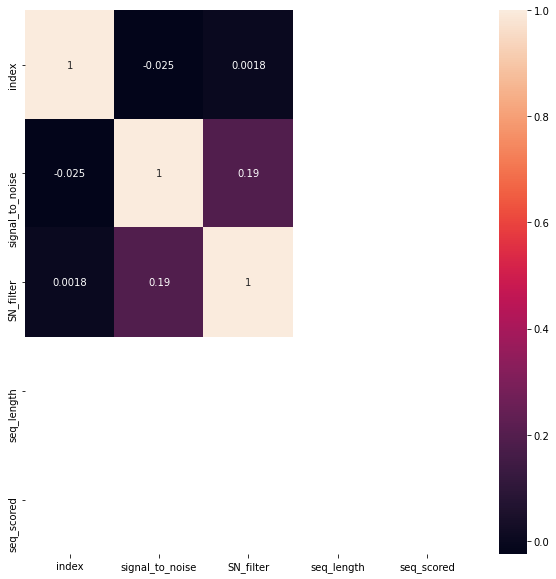

In [18]:
plt.figure(figsize=(10,10))
sns.heatmap(train.corr(), annot= True)

 On conclu donc qu'il n'y a pas de correlation entre ces variables

In [22]:
Ss = []
for i in tqdm(range(len(train))):
    seq_length = train["seq_length"].iloc[i]
    structure = train["structure"].iloc[i]
    sequence = train["sequence"].iloc[i]

    cue = []
    a_structures = {
        ("A", "U") : np.zeros([seq_length, seq_length]),
        ("C", "G") : np.zeros([seq_length, seq_length]),
        ("U", "G") : np.zeros([seq_length, seq_length]),
        ("U", "A") : np.zeros([seq_length, seq_length]),
        ("G", "C") : np.zeros([seq_length, seq_length]),
        ("G", "U") : np.zeros([seq_length, seq_length]),
    }
    a_structure = np.zeros([seq_length, seq_length])
    for i in range(seq_length):
        if structure[i] == "(":
            cue.append(i)
        elif structure[i] == ")":
            start = cue.pop()
#                 a_structure[start, i] = 1
#                 a_structure[i, start] = 1
            a_structures[(sequence[start], sequence[i])][start, i] = 1
            a_structures[(sequence[i], sequence[start])][i, start] = 1
        
    a_strc = np.stack([a for a in a_structures.values()], axis = 2)
    a_strc = np.sum(a_strc, axis = 2, keepdims = True)
    Ss.append(a_strc)
    
Ss = np.array(Ss)
print(Ss.shape)


(2096, 107, 107, 1)


verifier les prédictions avec d'autres méthodes de prediction de structures secondaires.
voir si les sequences se ressemble = les jeux ne sont pas independat faudrait donc les pondérer 
les séquences commencent toutes de la meme maniere. or qu'on ajoute des données de anieres différents



structure du réseau: 
réseau convolutionnel, puis on passe un flatten (68*3

les output faudrait reduire pour avoir 68 en sortie à la fin sauf que de l'autre coté on a 91.  Alors soit on partage les données en 2 : on a un vectur en entrée de 107 on aura donc 68, on coupe en 2, et on decale de 23(130-107) = (91-68) donc celui de 130 on coupe en 2 et on prend 23 en amont, 1-107 puis 23-130 puis retirer les doublons 


on peut aussi cacher les dpnnées manquante, on tronque une partie du réseau à la declaration ( tt les elemts au delas 68)
cela ne va pas fausser le kernel. 

faire une crosse validation sur le test 



commencer par du 1d réseau classique 